In [1]:
import qrcode
import numpy as np
from matplotlib import pyplot as plt
import random
import string

In [104]:
CMAP = 'magma'

def create_code():
  s = ''.join(random.choices(string.ascii_lowercase, k=14))
  pil_img = qrcode.make(s, box_size=1, border=0,)
  np_img = np.array(pil_img.getdata()).reshape(pil_img.size[0], pil_img.size[1], 1)
  np_array = np.concatenate(np.concatenate(np_img))//255
  return np_array

def create_noise():
  return np.array([random.randint(0, 1) for i in range(441)])

def reshape_code(qr):
  s = int((qr.shape[0])**0.5)
  return qr.reshape(s, s)

def show_code(qr):
  fig, ax = plt.subplots(1, 1, figsize=(4, 4))
  plt.setp(ax, xticklabels=[], yticklabels=[])
  ax.axis("off")
  plt.imshow(reshape_code(qr), cmap=CMAP, vmin=0, vmax=1)

def crash_code(qr, alpha):
  for i in range(qr.shape[0]):
    if random.random() <= alpha:
      qr[i] = int(not qr[i])
  return qr

def plot_codes(X, y_true=None, y_pred=None):
  fig, ax = plt.subplots(1, X.shape[0], figsize=(3*X.shape[0], 2))
  plt.setp(ax, xticklabels=[], yticklabels=[])

  line = 'b'
  lw = 4

  for i in range(X.shape[0]):
    title = ""
    if y_true is not None:
      title += f"Real: {bool(y_true[i])}\n"
    if y_pred is not None:
      title += f"Predict: {bool(int(y_pred[i]))}"
    ax[i].axis("off")
    ax[i].title.set_text(title)
    ax[i].title.set_size(25)
    ax[i].imshow(reshape_code(X[i, :]), cmap=CMAP, vmin=0, vmax=1)

def shuffle(X, y):
  n = len(y)
  a = [(random.random(), X[i, :], y[i]) for i in range(n)]
  a.sort()
  new_X = np.array([a[i][1] for i in range(n)])
  new_y = np.array([a[i][2] for i in range(n)])
  return new_X, new_y

Создадим 5 qr-кодов

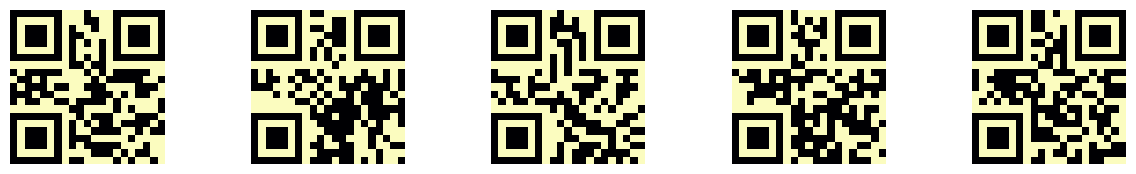

In [3]:
n = 5
X = np.array([create_code() for i in range(n)])
plot_codes(X)

Создадим 5 изображений, которые притворяются правильными qr-кодами

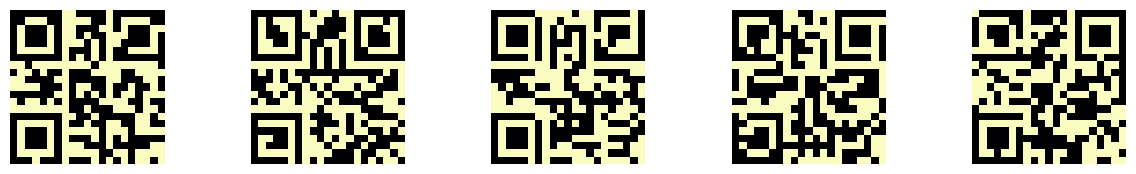

In [4]:
n = 5
X = np.array([crash_code(create_code(), 0.075) for i in range(n)])
plot_codes(X)

Формируем датасет

In [105]:
n = 10
X = np.array([crash_code(create_code(), 0.075) for i in range(6)] +
            [[0]*441, [1]*441] +
            [create_noise() for i in range(2)] +
            [create_code() for i in range(n)])
y = np.array([0]*n + [1]*n)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [106]:
X_, y_ = shuffle(X, y)
y_

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1])

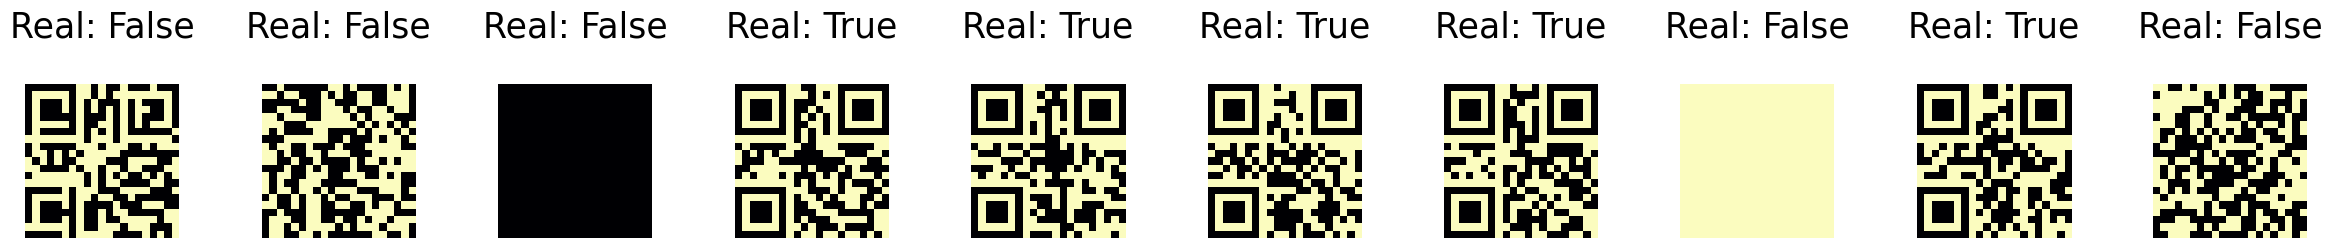

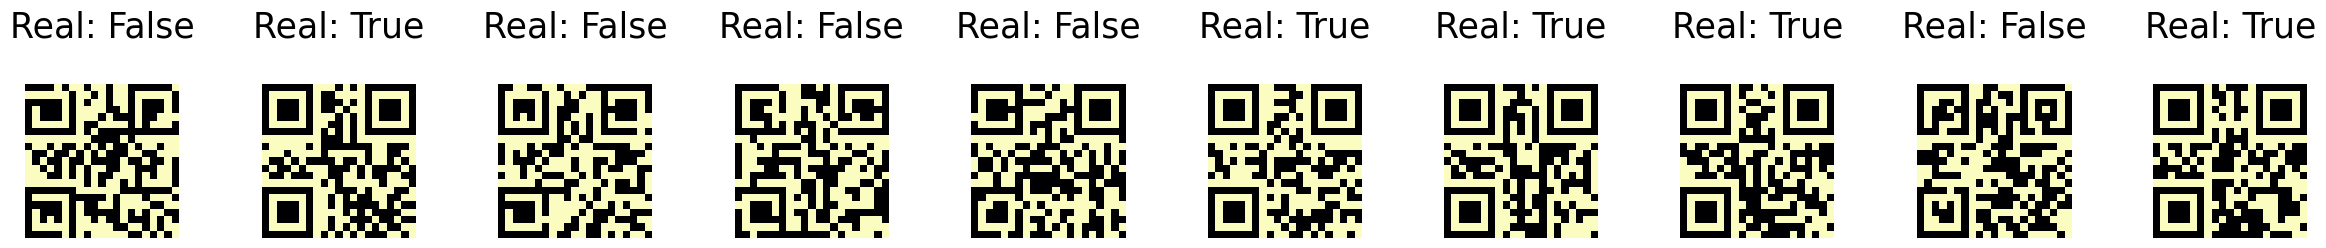

In [ ]:
plot_codes(X_[:10, :], y_true=y_[:10])
plot_codes(X_[10:, :], y_true=y_[10:])

In [108]:
class Perceptron:
  def __init__(self, hidden_layers, activations, eta=1, n_epochs=100):
    self.layers = []
    self.epochs = n_epochs
    self.eta = eta
    self.errors = []
    l = hidden_layers + [1]
    for i in range(len(hidden_layers)):
      self.layers.append(Layer((l[i]+1, l[i+1]), activations[i], i + 1))

  def predict(self, X, logging=False):
    result = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
      x = X[i, :]
      for layer in self.layers:
        x = np.append(x, values=[1])
        x = layer.forward(x, logging)
        
      result[i] = x[0]
      if logging:
        print(result[i])
    return result

  def train(self, X, y, logging=False):
    self.layers = [Layer((X.shape[1]+1, self.layers[0].size[0]-1), np.sign, 0)] + self.layers
    for _ in range(self.epochs):
      error = 0
      for i in range(X.shape[0]):
        x = X[i, :]

        for layer in self.layers:
          x = np.append(x, values=[1])
          x = layer.forward(x, logging)

        ans = x[0]
        delta = y[i] - ans
        error += abs(delta)

        for layer in self.layers:
          layer.backward(self.eta*delta)
          #print(layer.w)
      self.errors.append(error)
    return self.errors


class Layer:
  def __init__(self, size, activation, index, value=0):
    self.size = size
    self.w = np.full(size, value)
    self.activation = np.vectorize(activation)
    self.i = index
    self.last_result = np.array([])
    self.last_x = np.array([])

  def backward(self, value):
    if value > 0: 
      # надо увеличить те веса, где нет активации,
      # но должна быть активация  
      d = (self.last_x>0)*value
      d = np.repeat(np.array([d]).T, self.w.shape[1], axis=1)
      # print("d:", d)
      # print(self.w.shape, d.shape)
      self.w = self.w + d
    if value < 0: 
      # надо уменьшить те веса, 
      # где активации быть не должно
      d = (self.last_x>0)*value
      d = np.repeat(np.array([d]).T, self.w.shape[1], axis=1)
      # print("d:", d)
      # print(self.w.shape, d.shape)
      self.w = self.w + d

  def forward(self, x, logging):
    if logging:
      print(f"Слой №{self.i+1}")
      print(f"Сенсоры  : {x}")
      print(f"Размер: {self.size}")
      
    m = np.dot(x, self.w)
    result = self.activation(m)
    self.last_result = result
    self.last_x = x
    if logging:
      print(f"Сумматор : {m}")
      print(f"Активация: {result}")
      print(f"Результат размера {result.shape}")
    
    return result

In [114]:
step = lambda x: int(x >= 0)
pcp = Perceptron([10], [step], n_epochs=100)
print([i.size for i in  pcp.layers])
errors = pcp.train(X_, y_, logging=False)

[(11, 1)]


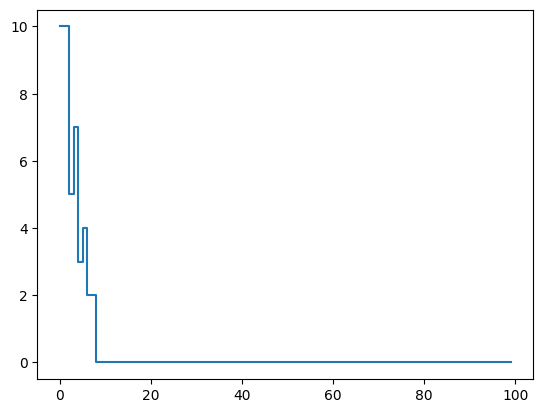

In [115]:
plt.step([i for i in range(len(errors))], errors)

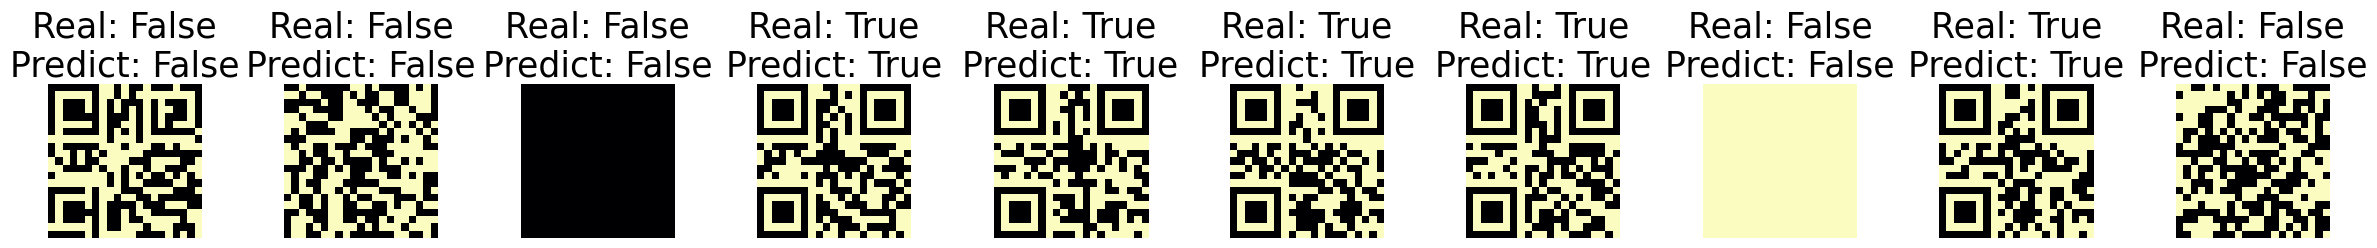

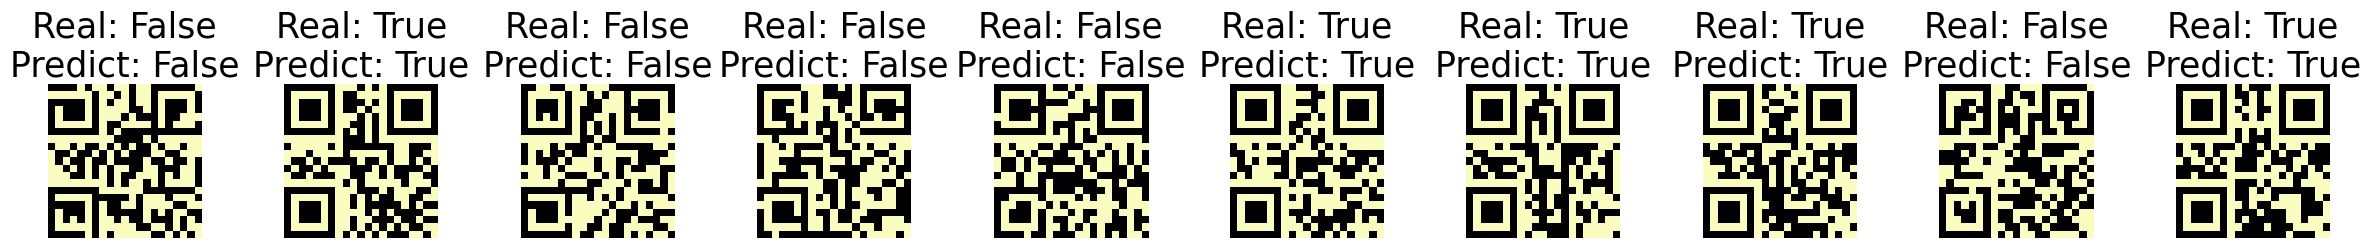

In [116]:
y_pred = pcp.predict(X_)
plot_codes(X_[:10, :], y_true=y_[:10], y_pred=y_pred[:10])
plot_codes(X_[10:, :], y_true=y_[10:], y_pred=y_pred[10:])

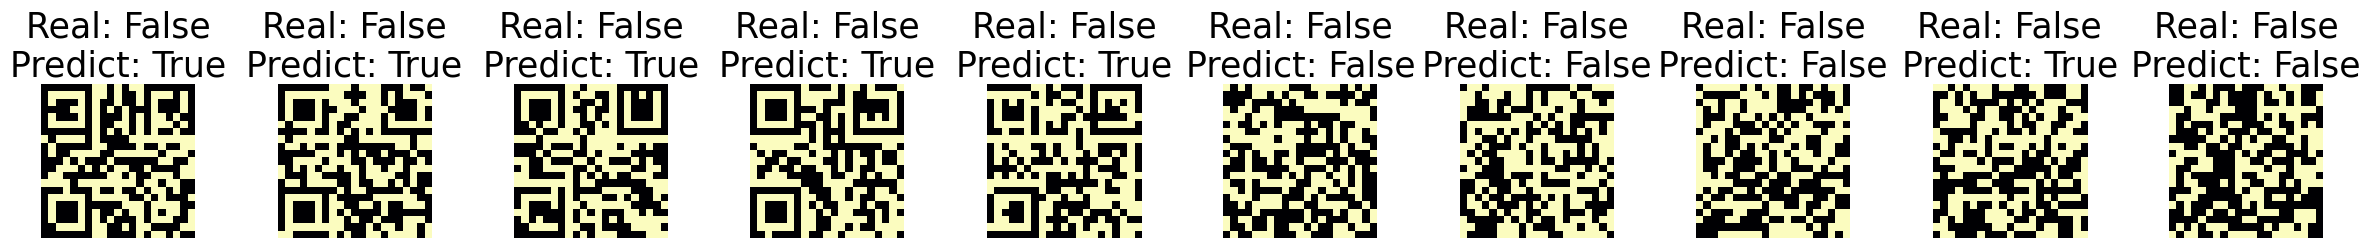

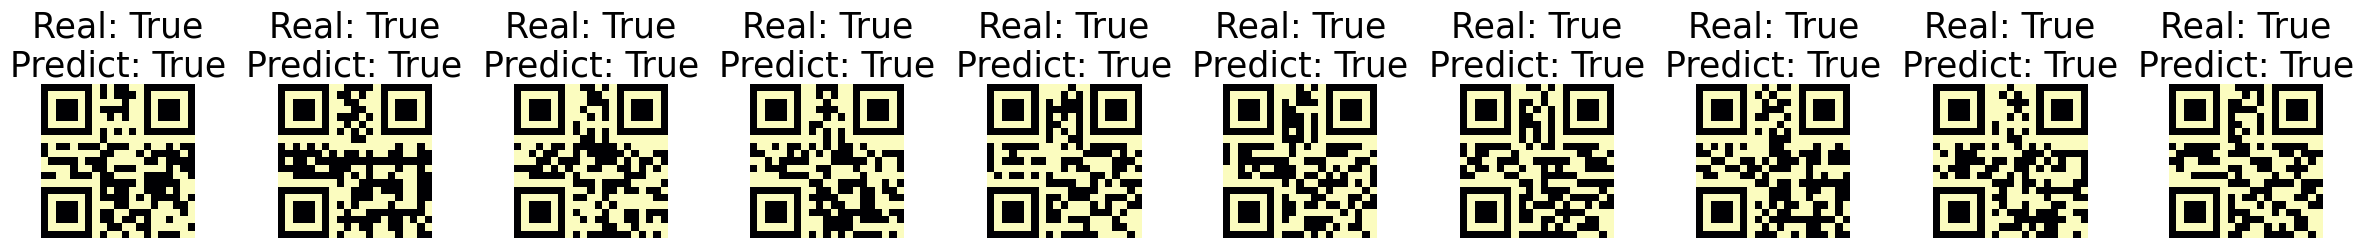

In [130]:
n = 10
X_val = np.array([crash_code(create_code(), 0.075) for i in range(n//2)] +
              [create_noise() for i in range(n//2)] +
              [create_code() for i in range(n)])
y_val = np.array([0]*n + [1]*n)
y_val_pred = pcp.predict(X_val)

plot_codes(X_val[:10, :], y_true=y_val[:10], y_pred=y_val_pred[:10])
plot_codes(X_val[10:, :], y_true=y_val[10:], y_pred=y_val_pred[10:])

[(442, 121), (122, 121), (122, 21), (22, 1)]


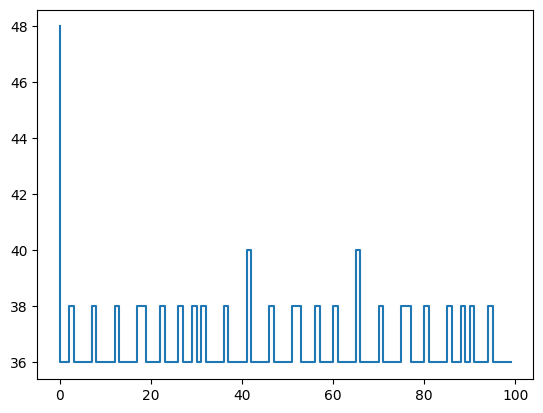

In [129]:
n = 50
X = np.array([crash_code(create_code(), 0.075) for i in range(n//2)] +
            [[0]*441, [1]*441] +
            [create_noise() for i in range((n//2) - 2)] +
            [create_code() for i in range(n)])
y = np.array([0]*n + [1]*n)
X_, y_ = shuffle(X, y)

step = lambda x: int(x >= 0)
pcp = Perceptron([441, 121, 121, 21], [step, step, step, step], n_epochs=100)
print([i.size for i in  pcp.layers])
errors = pcp.train(X_, y_, logging=False)

plt.step([i for i in range(len(errors))], errors)